### Unsupervised Learning - Part 1 : Practical Task #6:
##### Adapted by Dr. Mohammed Hadi from solution by Dr Katrina Jones (ML Module, 2021)

-----------


### Instructions:

1. Download the datasets pop1.csv – pop4.csv. 

2. Create a scatter plot of each dataset. 

Datasets contains a population of 2D variables, generated from a mixture of Gaussian distributions. We will try to separate each into two clusters using the k-means and the EM algorithm.




-------------
## Task 1: create a k-means algorithm from scratch (without using sklearn)

In this task, we will implement the k-means algorithm. Recall that the pseudocode for k-means is as follows:

-----


BEGIN <br />
&emsp; INITIALISE k cluster centres <br />
&emsp; REPEAT UNTIL converged DO <br />
&emsp; &emsp; FOR EACH data point DO <br />
&emsp; &emsp; &emsp; ASSIGN data point to closest cluster centre <br />
&emsp; &emsp; OD <br />
&emsp; &emsp; FOR EACH cluster centre DO <br />
&emsp; &emsp; &emsp; REPLACE cluster centre with mean of assigned data points <br />
&emsp; &emsp; OD <br />
&emsp; OD <br />
END <br />

_A few things to keep in mind when implementing the algorithm:_

- k (<u>the number of cluster centres</u>) should be a parameter of your algorithm.
- A cluster centre is a point in feature space. Your cluster centres, therefore, should have the same dimensionality as your features. <u>In the lecture, we discussed a good method for choosing initial cluster centres</u>.
- We can <u>test for convergence </u>either by testing whether the cluster centres remain the same in two iterations or by testing whether the allocation of data points to clusters remains the same. The latter is easier in practice as the former requires the comparison of double valued vectors.
- When we refer to “closest” in k-means, we mean closest in Euclidean distance in feature space.


-----------


### Step #1: Importing the relevant modules and data

Before we start, we should import the data and modules we will need to complete this task.

In [1]:
import pandas as pd   # We require pandas to import the data from the csv files.
import numpy as np    # We require numpy for the implementation of k-means.
import matplotlib.pyplot as plt # We require pyplot to visualise the data.

# Import the data -> pop1.csv -> pop4.csv
pop1 = pd.read_csv("pop1.csv").values
pop2 = pd.read_csv("pop2.csv").values
pop3 = pd.read_csv("pop3.csv").values
pop4 = pd.read_csv("pop4.csv").values

# Check that the shape (size of the datasets) are correct for our csvs to ensure no data has been lost or has become unreadable.
print("|| Pop 1: " + str(pop1.shape) + "|| Pop 2: " + str(pop2.shape) + "|| Pop 3: " + str(pop3.shape) + "|| Pop 4: " + str(pop4.shape) + "||")

|| Pop 1: (299, 2)|| Pop 2: (299, 2)|| Pop 3: (299, 2)|| Pop 4: (299, 2)||


### Step #2: Initially placing each population's data on a scatter graph.

Before we start, we should try to visualise what the data looks like without clustering.

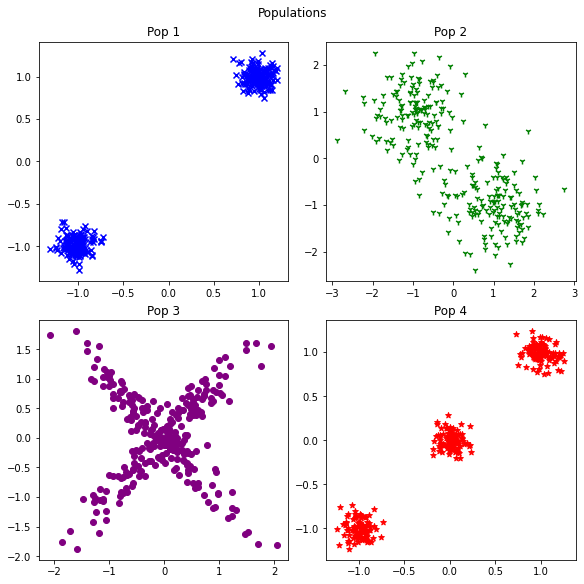

In [2]:
# Plot all the populations on a 2x2 grid: 
# the position for the subplots as shown below, 

# | [0,0] | [0,1] | #
# | [1,0] | [1,1] | #

fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(8,8)

# Give the whole figure a title
fig.suptitle("Populations")

# Pop 1 has 299 rows, and two columns - the two columns can be labelled x (column 0) and y (column 1). 
# Let's label these points in blue with 'x'.
ax[0][0].scatter(pop1[:,0], pop1[:,1], color="blue", marker="x")
ax[0][0].set_title("Pop 1")

# Pop 2 has 299 rows, and two columns - the two columns can be labelled x (column 0) and y (column 1). 
# Let's label these points in green with a triangle (1).
ax[0][1].scatter(pop2[:,0], pop2[:,1], color="green", marker="1")
ax[0][1].set_title("Pop 2")

# Pop 3 has 299 rows, and two columns - the two columns can be labelled x (column 0) and y (column 1). 
# Let's label these points in purple with a 'o'.
ax[1][0].scatter(pop3[:,0], pop3[:,1], color="purple", marker="o")
ax[1][0].set_title("Pop 3")

# Pop 4 has 299 rows, and two columns - the two columns can be labelled x (column 0) and y (column 1). 
# Let's label these points in red with a '*'.
ax[1][1].scatter(pop4[:,0], pop4[:,1], color="red", marker="*")
ax[1][1].set_title("Pop 4")

plt.show()

----------

### Task 1: Create a K-means class from scratch using the pseudocode...

BEGIN <br />
&emsp; INITIALISE k cluster centres <br />
&emsp; REPEAT UNTIL converged DO <br />
&emsp; &emsp; FOR EACH data point DO <br />
&emsp; &emsp; &emsp; ASSIGN data point to closest cluster centre <br />
&emsp; &emsp; OD <br />
&emsp; &emsp; FOR EACH cluster centre DO <br />
&emsp; &emsp; &emsp; REPLACE cluster centre with mean of assigned data points <br />
&emsp; &emsp; OD <br />
&emsp; OD <br />
END <br />

----------------
#### Remember the Euclidean Distance [[1]](https://www.cut-the-knot.org/pythagoras/DistanceFormula.shtml) ?

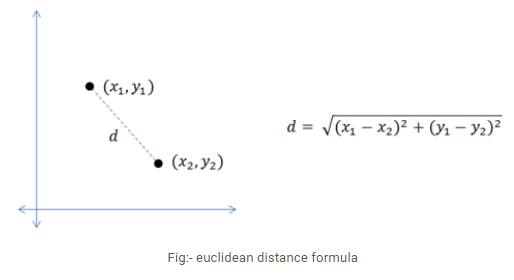


----------

In [4]:

''' Helper function for the Euclidean Distance '''
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum(x1-x2)**2)

# now we start with the Kmeans algorithm, starting by defining a class,

''' This is the KMeans class... using random cluster centering '''

class KMeans:
    
    ''' The constructor: function that happens when KMeans is created. (initialises an object that does not yet exists)'''
    
    # Mandatory parameters: 
    # - name - title of the dataset you wish to use.
    # - number_of_clusters - the value of K (you can set that to a default value, e.g., 2 or 3)
        
    # Optional parameters:
    # - max_iterations - the maximum number of iterations which the program should stop at if convergence hasn't been met (default: 50)
    # - print_calculate_convergence - whether we want to print the outcome of each step of convergence.
    # - print_calculate_centroids - whether we want to print out each calculation - WARNING, THIS SHOULD ONLY BE USED FOR SHORT RUNS - MAX ITERATIONS 5 - as it prints a lot of statements.
    
    def __init__(self, name, number_of_clusters, max_iterations, print_calculate_convergence=False, print_calculate_centroids=False): # Default value of anything that prints steps, if omitted is False as it takes less time to run.
        # BEGIN
        self.number_of_clusters = number_of_clusters      # i.e., k = number of clusters
        self.max_iterations = max_iterations              # maximum number of iterations in case convergence doesn't occur.
        
        self.clusters = [] * self.number_of_clusters      # Set the number of clusters to be limited to the number of clusters specified by the user.
        self.centroids = []                               # Let's have a list of centroids...
        
        self.name = name                                  # Name of the population/data.
        
        self.print_calculate_centroids = print_calculate_centroids       # a helper if we want to print prompts - WARNING, lot of print prompts if max_iterations is high.
        self.print_calculate_convergence = print_calculate_convergence   # a little helper in case we want helpful print prompts.
        self.current_step_number = 0                                     # to count how many times the process occurs.
    
    
    ''' Task 1 '''
    def predict(self, x):
        # BEGIN
        self.x = x                                 # x is the dataset (i.e, populatio) that will be passes to this method.
        self.n_samples, self.n_features = x.shape
        
        # INITIALISE k cluster centres
        random_sample_idxs = np.random.choice(self.n_samples, self.number_of_clusters, replace=False)
        self.centroids = [self.x[idx] for idx in random_sample_idxs]
        
        # Optimise clusters - make them appear in the 'ideal' positions based on the closest centroid function.
        # We will stop after the specified number of iterations.
        for iteration_number in range(self.max_iterations):
           
            # FOR EACH data point -> ASSIGN data point to closest cluster centre --> check method "create_clusters" below
            self.clusters = self.create_clusters(self.centroids)
            
            # Calculate new centroids from the clusters
            # FOR EACH cluster centre -> REPLACE cluster centre with mean of assigned data points
            centroids_old = self.centroids
            self.centroids = self.get_centroids(self.clusters)
            
            # REPEAT UNTIL converged -> check if clusters have changed, if not, we can stop.
            if self.is_converged(centroids_old, self.centroids):
                break
                
        self.plot()
        # Classify samples as the index of their clusters
        # return self._get_cluster_labels(self.clusters) # the equivalent of y_pred
    
    ''' A method that takes the data points and assigns them to the closest centroid. '''
    def create_clusters(self, centroids):
        # Create an array of size clusters...
        clusters = [[] for _ in range(self.number_of_clusters)]
        
        # FOR EACH data point -> ASSIGN data point to closest cluster centre 
        for index, data_point in enumerate(self.x):
            centroid_index = self.calculate_closest_centroid(data_point, centroids)
            clusters[centroid_index].append(index)
        
        # Return a list of those clusters...
        return clusters
    
    ''' How the closest centroid is calculated. '''
    def calculate_closest_centroid(self, data_point, centroids):
        # ASSIGN data point to closest cluster centre 
        distances = []
        for centroid_position in centroids:
            euclidean_value = euclidean_distance(data_point, centroid_position) # Euclidean distance.
            if self.print_calculate_centroids:
                print("Step [" + str(self.current_step_number) + "] :: Calculating the euclidean value for centroid " + str(centroid_position) + " and data point: " + str(data_point) + "which is:" + str(euclidean_value))
                self.current_step_number += 1
            distances.append(euclidean_value)
        closest_index = np.argmin(distances)
        return closest_index
    
    
    def get_centroids(self, clusters):
        centroids = np.zeros((self.number_of_clusters, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.x[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    
    
    def is_converged(self, centroids_old, centroids):
        distances = []
        for i in range(self.number_of_clusters):
            distances.append(euclidean_distance(centroids_old[i], centroids[i]))
        result_of_converged = sum(distances) == 0               # In other words, have they changed? If not, we should stop!
        if self.print_calculate_convergence:
                print("Step [" + str(self.current_step_number) + "] :: Checking whether the centroids have converged for " + self.name + ": " + str(result_of_converged))
                self.current_step_number += 1
        return result_of_converged
    
    ''' Plot a graph of the results... '''
    def plot(self):
        fig, ax = plt.subplots(figsize=(12,8))
        plt.title(self.name)
        
        markers = ['x', 'o', '*', '1', '2', '3', '4', 'x', 'o']
        colours = ['green', 'magenta', 'turquoise', 'red', 'yellow', 'purple', 'blue', 'turquoise']
        
        for index, cluster in enumerate(self.clusters):
            point = self.x[cluster].T
            if not index >= len(markers)-1 or not index >= len(colours)-1:
                ax.scatter(*point, marker=markers[index], color=colours[index])
            else:
                ax.scatter(*point)
            
        for centroid in self.centroids:
            ax.scatter(*centroid, marker="x", color='black')
        
        plt.show()

### Step #4: Using our custom K-means class

Let's have a go! See what happens...

Step [0] :: Checking whether the centroids have converged for Pop1: False
Step [1] :: Checking whether the centroids have converged for Pop1: False
Step [2] :: Checking whether the centroids have converged for Pop1: True


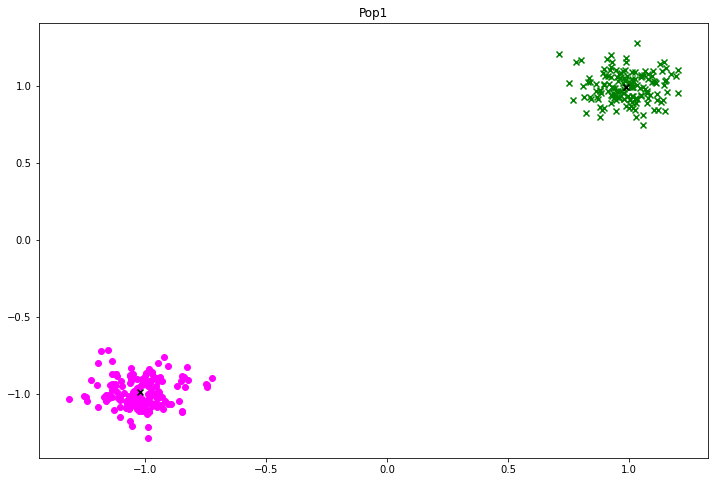

Step [0] :: Checking whether the centroids have converged for Pop2: False
Step [1] :: Checking whether the centroids have converged for Pop2: False
Step [2] :: Checking whether the centroids have converged for Pop2: False
Step [3] :: Checking whether the centroids have converged for Pop2: False
Step [4] :: Checking whether the centroids have converged for Pop2: False
Step [5] :: Checking whether the centroids have converged for Pop2: False
Step [6] :: Checking whether the centroids have converged for Pop2: True


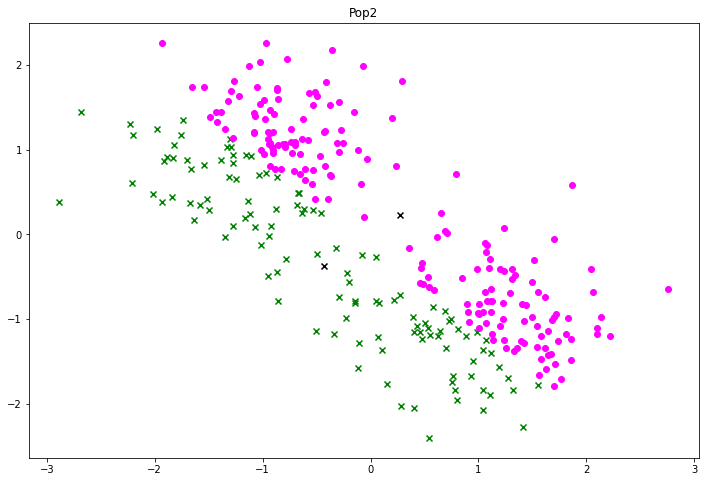

Step [0] :: Checking whether the centroids have converged for Pop3: False
Step [1] :: Checking whether the centroids have converged for Pop3: False
Step [2] :: Checking whether the centroids have converged for Pop3: False
Step [3] :: Checking whether the centroids have converged for Pop3: False
Step [4] :: Checking whether the centroids have converged for Pop3: False
Step [5] :: Checking whether the centroids have converged for Pop3: False
Step [6] :: Checking whether the centroids have converged for Pop3: False
Step [7] :: Checking whether the centroids have converged for Pop3: True


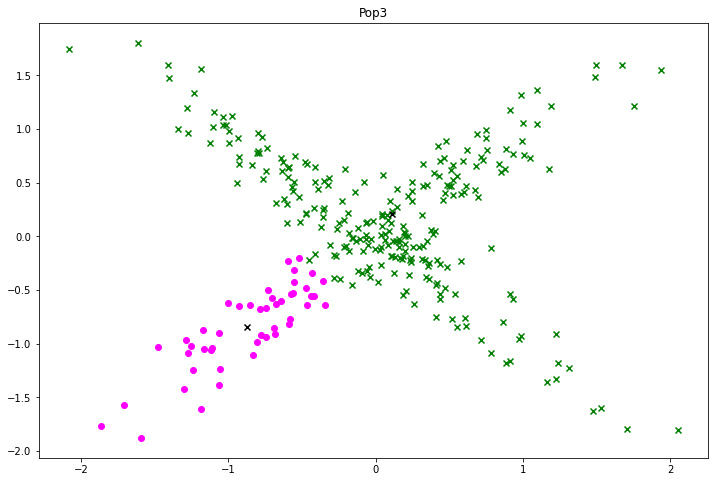

Step [0] :: Checking whether the centroids have converged for Pop4: False
Step [1] :: Checking whether the centroids have converged for Pop4: True


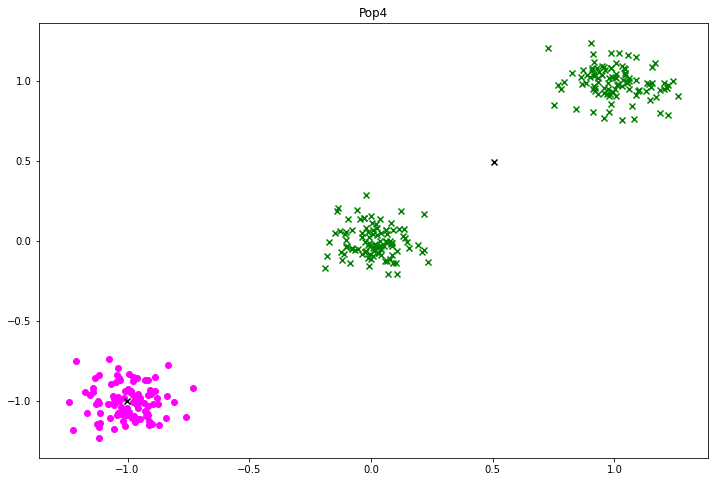

In [5]:
# Make our K-means objects, predict, and then plot.

k_pop1 = KMeans(name="Pop1", number_of_clusters=2, max_iterations=50, print_calculate_convergence=True, print_calculate_centroids=False)
k_pop1.predict(pop1)

k_pop2 = KMeans(name="Pop2", number_of_clusters=2, max_iterations=50, print_calculate_convergence=True, print_calculate_centroids=False)
k_pop2.predict(pop2)

k_pop3 = KMeans(name="Pop3", number_of_clusters=2, max_iterations=50, print_calculate_convergence=True, print_calculate_centroids=False)
k_pop3.predict(pop3)

k_pop4 = KMeans(name="Pop4", number_of_clusters=2, max_iterations=50, print_calculate_convergence=True, print_calculate_centroids=False)
k_pop4.predict(pop4)
